<h1 align="center"><font color="yellow">GPT privado: ajuste fino LLM em dados corporativos</font></h1>

<font color="yellow">Data Scientist.: Dr.Eddy Giusepe Chirinos Isidro</font>

Este Notebook é um estudo baseado no post de [Medium: Priya Dwivedi]().

# Introdução

Na era do `Big Data` e da `Inteligência Artificial` avançada, os modelos de linguagem emergiram como ferramentas formidáveis ​​capazes de processar e gerar texto semelhante ao humano. Grandes Modelos de Linguagem (LLM) como o `ChatGPT` são bots de uso geral capazes de conversar sobre vários tópicos. No entanto, os LLMs também podem ser `fine-tuned` em dados específicos do domínio, tornando-os mais accurate e pontual em questões corporativas específicas do domínio.

Muitas indústrias e aplicações exigirão LLMs bem ajustados (`fine-tuned`). As razões incluem:

* Melhor desempenho de um chatbot treinado em dados específicos

* Modelos `OpenAI` como `chatgpt` são uma caixa preta e as empresas podem hesitar em compartilhar seus dados confidenciais por meio de uma `API`

* Os custos da `API do ChatGPT` podem ser proibitivos para aplicativos grandes

O desafio de ajustar um LLM é que o **processo é desconhecido** e os recursos computacionais necessários para treinar um modelo de bilhões de parâmetros sem otimizações podem ser proibitivos.

Felizmente, muita pesquisa foi feita sobre técnicas de treinamento que nos permitem agora fazer fine-tune de LLMs em `GPUs` menores.


Neste Notebook, abordaremos algumas das técnicas usadas para fine-tuning dos LLMs. Vamos treinar o [Modelo Falcon 7B](https://huggingface.co/blog/falcon) em dados financeiros em uma `GPU Colab`! As técnicas usadas aqui são gerais e podem ser aplicadas a outros modelos maiores como `MPT-7B` e `MPT-30B`.

No [Deep Learning Analytics](https://deeplearninganalytics.org/), eles construíram modelos personalizados de aprendizado de máquina nos últimos $6$ anos. Entre em contato com eles se estiver interessado em ajustar um LLM para sua aplicação.



# <font color="red">QLoRA</font>

`QLoRA - Quantized Low-Rank Adaptation`, que significa `“Adaptação Quantizada Low-Rank”`, apresenta uma abordagem que combina quantização e adaptação de baixo escalão para obter um `fine-tuning` eficiente dos modelos de IA. Ambos os termos são explicados com mais detalhes abaixo.

O `QLoRA` reduz a memória necessária para o fine-tuning do LLM, sem qualquer queda no desempenho em relação a um modelo padrão de `16 bits` com fine-tuned. Esse método permite que um modelo de `7 bilhões` de parâmetros seja ajustado (fine-tuned) em uma `GPU` de `16 GB`, um modelo de `33 bilhões` de parâmetros seja ajustado em uma única `GPU` de `24 GB` e um modelo de `65 bilhões` de parâmetros seja ajustado em uma única `GPU` de `46 GB`.

Isso significa que a maioria das empresas agora pode ter LLMs ajustados ou modelos no local por um pequeno custo.

O `QLoRA` é composto por duas técnicas:

* LoRA — Adaptação de Nível Baixo (`Low-Rank Adaptation`)

* Quantização

# <font color="pink">LoRA</font>

`LoRA`, que significa `Low-Rank Adapters (LoRA)`, são pequenos conjuntos de parâmetros treináveis, injetados em cada camada da arquitetura do `Transformer` durante o ajuste fino. `Enquanto os pesos do modelo original são congelados` e `não atualizados`, esses pequenos conjuntos de pesos injetados são atualizados durante o ajuste fino. `Isso reduz bastante o número de parâmetros treináveis ​​para tarefas posteriores`. Os gradientes durante a descida de gradiente estocástico são passados ​​através dos pesos de modelo pré-treinados congelados para o adaptador. Assim, apenas esses adaptadores, com um `pequeno consumo de memória`, são atualizados durante o tempo de treinamento.

# <font color="pink">Quantization</font>

Em seguida, discutiremos a quantização. Para entender a quantização, primeiro precisamos conhecer os diferentes tipos de dados que geralmente são usados ​​para armazenar os pesos do modelo.

* `FP32` — Pesos de precision total que ocupam `4 bytes` de memória

* `FP16/BF16` — Pesos de meia precision que ocupam `2 bytes` de memória

* `INT8` — O tipo de dados consiste em uma representação de `8 bits` que pode armazenar $2^8$ valores diferentes (`entre [0, 255] ou [-128, 127] para números inteiros com sinal`)

* `FP8` e `FP4`, que representam precision de ponto flutuante de `8 bits` e `4 bits`, respectivamente. Eles fazem parte da família mini floats de valores de ponto flutuante.


`Usando a quantização, o modelo precisa de uma memória muito menor do que a memória necessária para armazenar o modelo original`. <font color="red">Por exemplo</font>, um modelo quantizado de `8 bits` exigiria apenas $\frac{1}{4}$ do tamanho do modelo, em comparação com um modelo armazenado em um tipo de dados de `32 bits`.



Mas como é possível armazenar o peso original de `32 bits` em tipos de dados de `8 bits` como `INT8` ou `FP8`?

`Quantização` significa `“arredondamento”` (rounding) de valores, de um tipo de dados para outro. Ele funciona espremendo (squeezing) valores maiores em tipos de dados com menos número de bits, mas com uma pequena loss de precision.

No caso do `QLoRA`, os pesos do modelo são armazenados em um tipo de dados de ponto flutuante de `4 bits`. Mas, para minimizar a perda geral de precision, todas as operações de matriz são executadas em um ponto flutuante de `16 bits`. Uma vez feito o cálculo, os pesos são `armazenados/quantizados` de volta, antes de serem armazenados novamente.


Para resumir, o `QLORA` usa um tipo de dados de armazenamento (normalmente `NormalFloat` de `4 bits`) e um tipo de dados de computação (`BrainFloat` de `16 bits`). O tipo de dados de armazenamento é desquantizado para o tipo de dados de computação para executar a passagem direta e reversa. Os pesos são descompactados apenas quando são necessários, portanto, o uso de memória permanece baixo durante o treinamento e a inferência. Mais detalhes sobre estes podem ser encontrados aqui: [Making LLMs even more accessible with bitsandbytes, 4-bit quantization and QLoRA](https://huggingface.co/blog/4bit-transformers-bitsandbytes#qlora-paper-a-new-way-of-democratizing-quantized-large-transformer-models)


E quanto aos impactos de accuracy do fine-tuning do `QLoRA`?

O ajuste QLoRA é mostrado para combinar métodos de ajuste fino de `16 bits` em uma ampla gama de experimentos. Além disso, os modelos `Guanaco`, que usam o ajuste fino `QLoRA` para modelos `LLaMA` no [Dataset OpenAssistant (OASST1)](https://huggingface.co/datasets/OpenAssistant/oasst1), são sistemas de `chatbot` de última geração e estão próximos do `ChatGPT` no `benchmark Vicuna`.

# Suporte HuggingFace para Fine-tuning

A `HuggingFace` lançou várias bibliotecas que podem ser usadas para fine-tune facilmente os `LLMs`.

Esses incluem:

* [Biblioteca PEFT](https://huggingface.co/blog/peft): A HuggingFace lançou uma biblioteca de Ajuste Fino Eficiente de Parâmetros (`PEFT Parameter Efficient Fine Tuning`) que tem suporte para `LORA`.

* `Suporte de quantização` — Muitos modelos podem ser carregados com precision de `8 bits` e `4 bits` usando o módulo `bitsandbytes`. A maneira básica de carregar um modelo em `4 bits` é passar o argumento `load_in_4bit=True` ao chamar o método `from_pretrained`.

* `Biblioteca Accelerate` — A biblioteca Accelerate tem muitos recursos para facilitar a redução dos requisitos de memória dos modelos

* [Treinador de ajuste fino supervisionado - Supervised Fine-Tuning Trainer](https://huggingface.co/docs/trl/main/en/sft_trainer#trl.SFTTrainer) — O `treinador SFT` é a `classe trainer` para ajuste fino supervisionado de grandes LLMs.


<font color="orange">Agora combinamos todas as técnicas aqui para treinar o modelo `Falcon 7B` em um conjunto de `Dados financeiros`.

# Treinamento do `Falcon 7B` no Dataset financeiro da `Alpaca`

Conseguimos ajustar com sucesso o modelo `Falcon-7B` lançado recentemente, no Dataset [Alpaca-Finance](https://huggingface.co/datasets/gbharti/finance-alpaca/viewer/gbharti--finance-alpaca/train?p=688), no `Google Colab`. Esse conjunto de dados consistia em cerca de `70 mil` pontos de dados financeiros. Este é um dado de código aberto disponível no hub do conjunto de dados `HuggingFace` e pode ser carregado diretamente do hub.
Dados são questões (`questions`) financeiras com respostas(`answer`). Um instantâneo (snapshot) dos dados é mostrado abaixo:

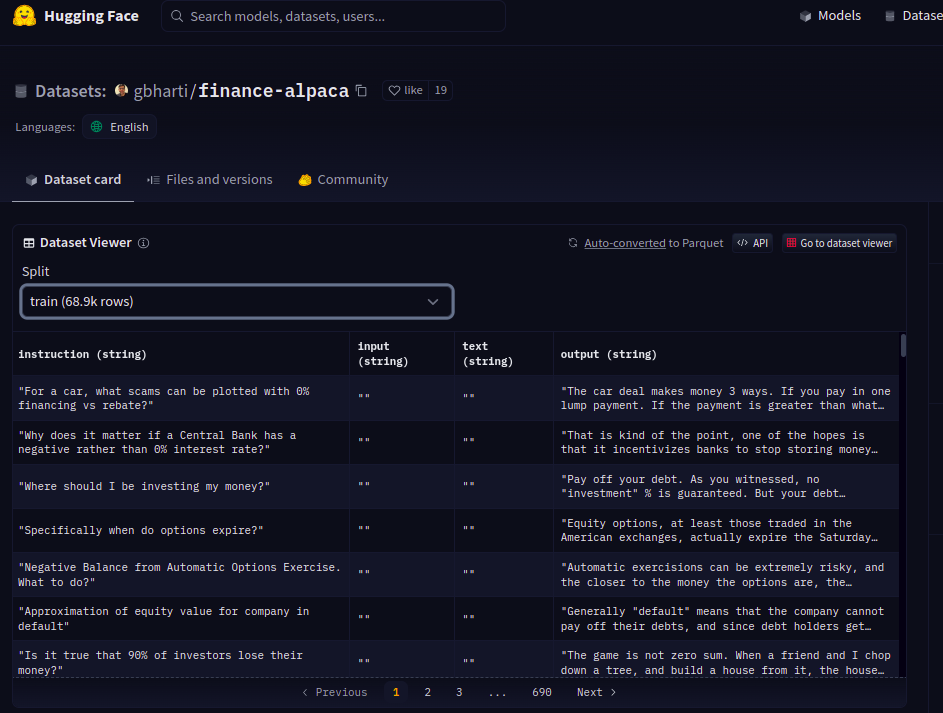

<font color="pink">Bora a realizar o fine-tune do modelo `Falcon-7B`.</font>